In [2]:
# Packages for model learning
import numpy as np
import sklearn.metrics

import torch
import torchvision
import gpytorch
import botorch

# Packages for data loading
import json
from pathlib import Path

In [3]:
# Packages for Jupyter notebook
import IPython.display as ipd
import matplotlib.pyplot as plt
import PIL
import base64

In [84]:
from functools import cache

tensor_to_image = torchvision.transforms.ToPILImage()
@cache
def tensor_to_url(tensor, size=128):
    return fr"data:image/png;base64,{base64.b64encode(PIL.ImageOps.contain(tensor_to_image(tensor), (size, size))._repr_png_()).decode('ascii')}"

# Load and process data

In [4]:
# Load dataset

# img_root = './dataset/dress_pure_renamed/'
# train_metadata = json.loads(Path('./dataset/dress_pure_renamed/train.json').read_text())
# test_metadata = json.loads(Path('./dataset/dress_pure_renamed/test.json').read_text())
# val_metadata = json.loads(Path('./dataset/dress_pure_renamed/val.json').read_text())

# class_labels = ['christian_dior', 'maison_margiela']
torch.manual_seed(0)
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device = "cpu"

img_root = '/home/sicelukwanda/modm/datasets/fashion_designers/'
train_metadata = json.loads(Path('/home/sicelukwanda/modm/datasets/fashion_designers/train.json').read_text())
test_metadata = json.loads(Path('/home/sicelukwanda/modm/datasets/fashion_designers/test.json').read_text())
val_metadata = json.loads(Path('/home/sicelukwanda/modm/datasets/fashion_designers/val.json').read_text())

class_labels = ["Alexander_McQueen_pure","donatella_versace_pure","Karl_Lagerfeld_pure","yves_saint_laurent_pure"]

n_train = len(train_metadata)
n_test = len(test_metadata)
n_val = len(val_metadata)

train_classes = torch.empty(n_train, dtype=torch.int)
train_images = [None]*n_train
for i,meta in enumerate(train_metadata):
    train_classes[i] = meta['label']
    train_images[i] = torchvision.io.read_image(img_root+meta['file_path']).to(device)

test_classes = torch.empty(n_test, dtype=torch.int)
test_images = [None]*n_test
for i,meta in enumerate(test_metadata):
    test_classes[i] = meta['label']
    test_images[i] = torchvision.io.read_image(img_root+meta['file_path']).to(device)

val_classes = torch.empty(n_test, dtype=torch.int)
val_images = [None]*n_val
for i,meta in enumerate(val_metadata):
    test_classes[i] = meta['label']
    val_images[i] = torchvision.io.read_image(img_root+meta['file_path']).to(device)

In [5]:
# Make all photos square
def pad_image(img):
    h,w = img.shape[1:]
    if h != w:
        new_w = max(h,w)
        pad_h, rem_h = divmod(new_w - h, 2)
        pad_w, rem_w = divmod(new_w - w, 2)
        padding = [pad_w, pad_h, pad_w+rem_w, pad_h+rem_h]
        return torchvision.transforms.functional.pad(img, padding, padding_mode='edge')
    return img

train_images = [pad_image(i) for i in train_images]
test_images = [pad_image(i) for i in test_images]
val_images = [pad_image(i) for i in val_images]

In [6]:
print(len(train_images))
print(len(test_images))
print(len(val_images))

837
240
120


In [7]:
class ResnetExtractor(torch.nn.Module):
    def __init__(self, remove_last_layer=True):
        super().__init__()
        weights = torchvision.models.ResNet18_Weights.DEFAULT
        self.resnet18 = torchvision.models.resnet18(weights=weights, progress=False).eval()
#         self.input_transform = weights.transforms(antialias=True)
        
        self.input_transform = weights.transforms()

        # Remove resnet last layer
        if remove_last_layer:
            self.resnet18.fc = torch.nn.Identity()

        # Freeze all the parameters
        for param in self.resnet18.parameters():
            param.requires_grad = False

    def forward(self, x):
        with torch.no_grad():
            y_pred = self.resnet18(x)
            return y_pred

# Define resnet feature extractor
resnet_extractor = ResnetExtractor(remove_last_layer=True).to(device)
crop_size = resnet_extractor.input_transform.crop_size[0]

train_data = torch.empty((n_train, 3, crop_size, crop_size)).to(device)
test_data = torch.empty((n_test, 3, crop_size, crop_size)).to(device)
val_data = torch.empty((n_val, 3, crop_size, crop_size)).to(device)
for i in range(n_train):
    train_data[i] = resnet_extractor.input_transform(train_images[i])
for i in range(n_test):
    test_data[i] = resnet_extractor.input_transform(test_images[i])
for i in range(n_val):
    val_data[i] = resnet_extractor.input_transform(val_images[i])

train_embeddings = resnet_extractor(train_data)
test_embeddings = resnet_extractor(test_data)
val_embeddings = resnet_extractor(val_data)

training loss: 2.09:
training loss: 1.47:
training loss: 1.57:
training loss: 1.89:
training loss: 2.16:
training loss: 2.24:
training loss: 2.26:
training loss: 2.49:
training loss: 3.05:
training loss: 3.64:


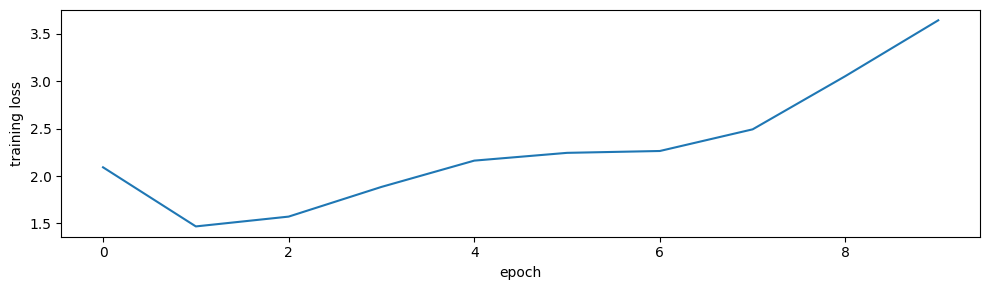

ROC-AUC 0.61
Acc 32.92 %


In [8]:
#res18 backbone
# Define resnet feature extractor
import torch, torch.nn as nn, torch.nn.functional as F
epoches = 10
resnet_backbone = ResnetExtractor(remove_last_layer=False).to(device)
fc = torch.nn.Linear(1000,len(class_labels)).train()
fc = fc.to(device)
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, fc.parameters()),lr=0.001)#, weight_decay=0.0004)

loss_record = []
for i in range(0,epoches):
    train_embeddings_res = resnet_backbone(train_data)
    output_res = fc(train_embeddings_res)
    output_res = F.log_softmax(output_res, dim=1)
    loss = F.nll_loss(output_res,train_classes.long())
    print('training loss: {:.2f}:'.format(loss.data))
    loss.backward()
    optimizer.step()
    loss_record.append(loss.data)

f,ax = plt.subplots(1,1,tight_layout=True,figsize=(10,3))
ax.plot([i for i in range(0,epoches)], loss_record)
ax.set_ylabel('training loss');ax.set_xlabel('epoch');
plt.show(f);plt.close(f)


##testing
test_embeddings_res = resnet_backbone(test_data)
output_res = fc(test_embeddings_res)
# pred = output_res.argmax(-1)
output_res = torch.softmax(output_res,dim=1).detach().cpu()

print('ROC-AUC',np.round(sklearn.metrics.roc_auc_score(
    test_classes,
    output_res,multi_class='ovr'
),2))

print('Acc',np.round(sklearn.metrics.accuracy_score(
    test_classes,
    output_res.argmax(-1)
)*100,2),'%')

# print(test_classes)
# print(output_res.argmax(-1))


# Define and train GP

In [89]:
class DirichletGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood, num_classes):
        super(DirichletGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean(batch_shape=torch.Size((num_classes,)))
        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.RBFKernel(batch_shape=torch.Size((num_classes,))),
            batch_shape=torch.Size((num_classes,)),
        )
        self.scaler = gpytorch.utils.grid.ScaleToBounds(-1,1)
        self.fc = torch.nn.Linear(train_x.shape[1],10)
        torch.nn.init.xavier_uniform_(self.fc.weight)

    def transform(self, x):
        x = self.fc(x)
        x = self.scaler(x)
        return x

    def forward(self, x):
        x = self.transform(x)
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

    def embedding_posterior(self, z):
        '''Compute the posterior over z = self.transform(x)'''
        assert self.prediction_strategy is not None
        fz_mean = self.mean_module(z)
        Kz = self.covar_module(z)
        Kzx = self.covar_module(z, self.transform(self.train_inputs[0]))
        return gpytorch.distributions.MultivariateNormal(
            self.prediction_strategy.exact_predictive_mean(fz_mean,Kzx),
            self.prediction_strategy.exact_predictive_covar(Kz, Kzx)
        )

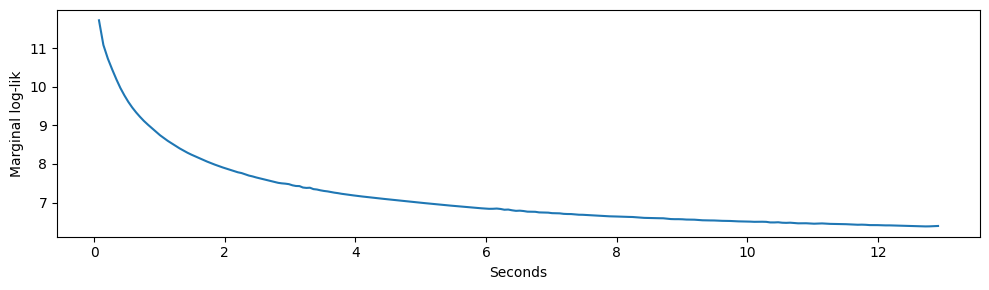

OptimizationStatus.STOPPED `torch_minimize` stopped due to `stopping_criterion`.


In [90]:
# initialize likelihood and model
torch.manual_seed(0)

# print(train_classes.long())
# likelihood = gpytorch.likelihoods.DirichletClassificationLikelihood(train_classes.long(), learn_additional_noise=True)
# model = DirichletGPModel(train_embeddings, likelihood.transformed_targets, likelihood, num_classes=likelihood.num_classes)
# # print(likelihood.num_classes)

likelihood = gpytorch.likelihoods.DirichletClassificationLikelihood(train_classes.long(), learn_additional_noise=True)
model = DirichletGPModel(train_embeddings, likelihood.transformed_targets, likelihood, num_classes=likelihood.num_classes)
# print(likelihood.num_classes)

mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

mll.train()

optimization_trace = []
botorch.optim.fit.fit_gpytorch_mll_torch(mll, step_limit=1000, optimizer=lambda p: torch.optim.Adam(p, lr=0.01), callback=lambda _,i: optimization_trace.append(i))
# botorch.optim.fit.fit_gpytorch_mll_scipy(mll, callback=lambda _,i: optimization_trace.append(i))

f,ax = plt.subplots(1,1,tight_layout=True,figsize=(10,3))
ax.plot([r.runtime for r in optimization_trace], [r.fval for r in optimization_trace])
ax.set_ylabel('Marginal log-lik');ax.set_xlabel('Seconds');
plt.show(f);plt.close(f)
print(optimization_trace[-1].status, optimization_trace[-1].message)

## Metrics

/home/sicelukwanda/anaconda3/envs/sd_automatic111/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(


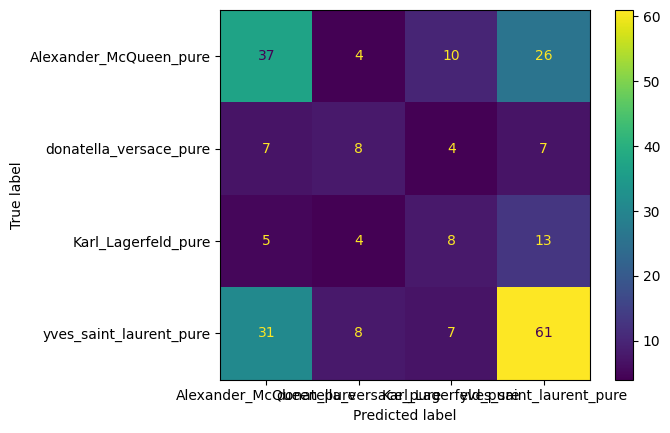

In [91]:
model.eval()
likelihood.eval()
with torch.no_grad():
    test_pred_dist = model(test_embeddings)

test_pred_samples = test_pred_dist.sample(torch.Size((256,))).exp()
test_probabilities = (test_pred_samples / test_pred_samples.sum(1, keepdim=True)).mean(0)

# print(class_labels)

# sklearn.metrics.ConfusionMatrixDisplay(
#     sklearn.metrics.confusion_matrix(test_classes, (test_probabilities[1] > 0.5)),
#     display_labels=class_labels
# ).plot();

sklearn.metrics.ConfusionMatrixDisplay(
    sklearn.metrics.confusion_matrix(test_classes, (torch.argmax(test_probabilities,dim=0,keepdim=False))),
    display_labels=class_labels
).plot();

/home/sicelukwanda/anaconda3/envs/sd_automatic111/lib/python3.10/site-packages/gpytorch/models/exact_gp.py:284: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(
/home/sicelukwanda/anaconda3/envs/sd_automatic111/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/home/sicelukwanda/anaconda3/envs/sd_automatic111/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(


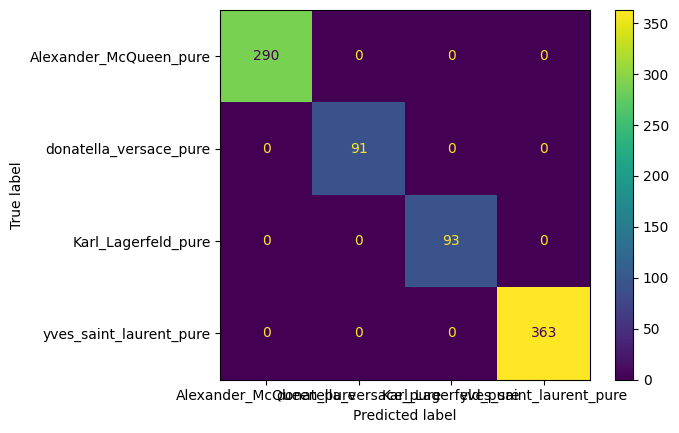

In [92]:
model.eval()
likelihood.eval()
with torch.no_grad():
    train_pred_dist = model(train_embeddings)

train_pred_samples = train_pred_dist.sample(torch.Size((256,))).exp()
train_probabilities = (train_pred_samples / train_pred_samples.sum(1, keepdim=True)).mean(0)

# print(class_labels)

# sklearn.metrics.ConfusionMatrixDisplay(
#     sklearn.metrics.confusion_matrix(test_classes, (test_probabilities[1] > 0.5)),
#     display_labels=class_labels
# ).plot();

sklearn.metrics.ConfusionMatrixDisplay(
    sklearn.metrics.confusion_matrix(train_classes, (torch.argmax(train_probabilities,dim=0,keepdim=False))),
    display_labels=class_labels
).plot();

In [93]:
# print('ROC-AUC',np.round(sklearn.metrics.roc_auc_score(
#     test_classes,
#     (test_probabilities[1] > 0.5),
# ),2))
# print('Acc',np.round(sklearn.metrics.accuracy_score(
#     test_classes,
#     (test_probabilities[1] > 0.5)
# )*100,2),'%')

# torch.max(test_probabilities,0)[0].shape
# test_classes.shape
# print(test_probabilities[:,1])

torch.softmax(test_probabilities,dim=0).t()

print('ROC-AUC',np.round(sklearn.metrics.roc_auc_score(
    test_classes,
    torch.softmax(test_probabilities,dim=0).t(),multi_class='ovr'
),2))

print('Acc',np.round(sklearn.metrics.accuracy_score(
    test_classes,
    (torch.argmax(test_probabilities,dim=0,keepdim=False))
)*100,2),'%')





ROC-AUC 0.62
Acc 47.5 %


In [82]:
# from sklearn.metrics import roc_auc_score

# def roc_auc_score_multiclass(actual_class, pred_class, average = "macro"):

#   #creating a set of all the unique classes using the actual class list
#   unique_class = set(actual_class)
#   roc_auc_dict = {}
#   for per_class in unique_class:
#     #creating a list of all the classes except the current class 
#     other_class = [x for x in unique_class if x != per_class]

#     #marking the current class as 1 and all other classes as 0
#     new_actual_class = [0 if x in other_class else 1 for x in actual_class]
#     new_pred_class = [0 if x in other_class else 1 for x in pred_class]

#     #using the sklearn metrics method to calculate the roc_auc_score
#     roc_auc = roc_auc_score(new_actual_class, new_pred_class, average = average)
#     roc_auc_dict[per_class] = roc_auc

#   return roc_auc_dict

# print("\nLogistic Regression")
# # assuming your already have a list of actual_class and predicted_class from the logistic regression classifier
# lr_roc_auc_multiclass = roc_auc_score_multiclass(test_classes, test_probabilities[1] > 0.5)
# print(lr_roc_auc_multiclass)


# Visualization

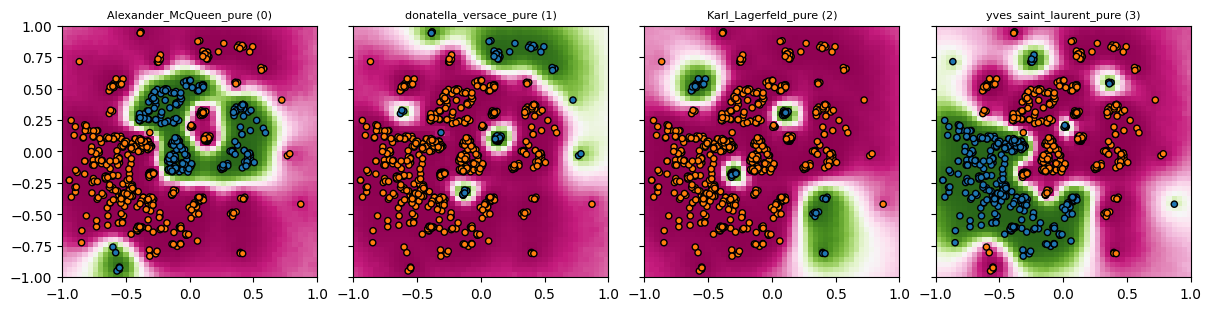

In [83]:
x_grid = torch.as_tensor(np.stack(np.meshgrid(np.linspace(-1,1), np.linspace(-1,1)), -1)).to(model.train_inputs[0])
y_grid = model.embedding_posterior(x_grid.view(-1,2))

y_grid = y_grid.sample(torch.Size((256,))).exp()
y_grid_mean = (y_grid / y_grid.sum(1, keepdim=True)).mean(0)

all_classes = sorted(train_classes.unique().numpy())
n_cols = 4
n_rows = int(np.ceil(len(all_classes)/n_cols))
f,axs = plt.subplots(
    n_rows,n_cols, figsize=(n_cols*3, n_rows*3),
    sharex=True, sharey=True, constrained_layout=True
)
for ax in axs.flat:
    ax.set_visible(False)
for i in range(len(all_classes)):
    ax = axs.flat[i]
    ax.set_visible(True)
    ax.set_title(f'{class_labels[i]} ({i})', fontsize=8)
    ax.imshow(
        y_grid_mean[i].view(x_grid.shape[:2]).numpy(force=True), cmap='PiYG',
        origin='lower', aspect='auto', extent=[-1,1,-1,1],
        vmin=0, vmax=1
    )
    ax.scatter(
        *model.transform((train_embeddings)).numpy(force=True).T,
        c=(train_classes != i),
        vmin=0, vmax=10, marker='o', cmap='tab10', edgecolor='k',
        s=20
    )
#     ax.scatter(
#         *model.transform((test_embeddings)).numpy(force=True).T,
#         c=(test_classes != i),
#         vmin=0, vmax=10, marker='X', cmap='tab10', edgecolor='k',
#         s=40
#     )

In [94]:
with torch.no_grad():
    kernel_test_train = model.covar_module(model.transform(test_embeddings), model.transform(train_embeddings)).evaluate().numpy()

In [87]:
%%html
<style>
    html {
        --small-size: 42px;
    }
    .small-box {
        width: calc(var(--small-size) - 4px); height: calc(var(--small-size) - 2px);
        border-top: 2px solid; border-left: 2px solid;
        //flex: 0 0 auto;
    }
    .small-holder {
        display: flex;
        flex-direction: column;
        flex-wrap: wrap;
        border: 2px solid;
        box-sizing: border-box;
        border-top: 0;
        border-left: 0;
        height: calc(var(--small-size) * 4);
        width: calc(var(--small-size)*2);
    }
    .small-holder > .small-box:nth-child(4n) {
        height: calc(var(--small-size) - 4px);
    }
    .big-box {
        width: calc(var(--small-size) * 4); height: calc(var(--small-size) * 4);
    }
    .img-box > img {
        //border-left: 1px dashed red;
        //border-right: 1px dashed red;
    }
    .border {
        border: 2px solid;
        box-sizing: border-box;
    }
    .img-box {}
    .img-box > img {
        display: block;
        margin: 0 auto;
        max-height: 100%;
        max-width: 100%;
    }
    *[data-class="0"] {
        border-left: 3px solid #1f77b4;
    }
    *[data-class="1"] {
        border-left: 3px solid #ff7f0e;
    }
    *[data-class="2"] {
        border-left: 3px solid #2ca02c;
    }
    *[data-class="3"] {
        border-left: 3px solid #d62728;
    }
</style>


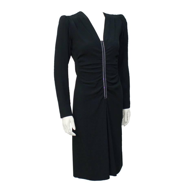
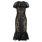
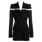
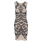
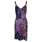
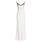
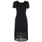
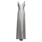
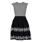
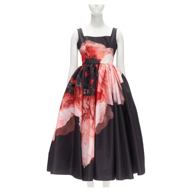
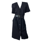
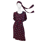
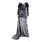
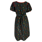
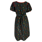
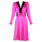
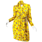
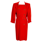
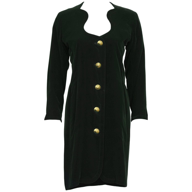
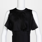
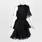
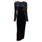
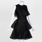
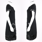
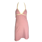
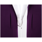
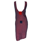
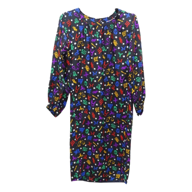
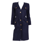
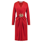
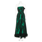
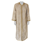
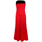
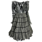
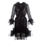
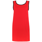
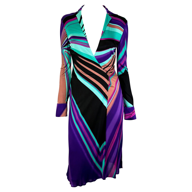
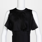
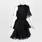
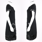
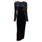
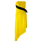
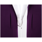
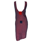
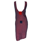
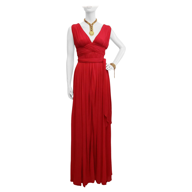
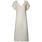
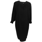
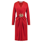
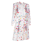
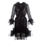
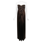
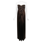
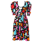
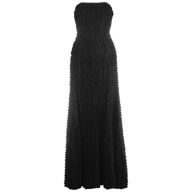
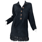
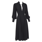
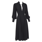
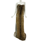
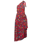
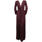
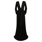
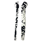
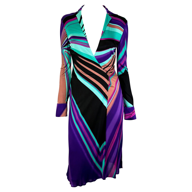
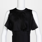
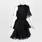
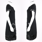
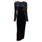
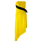
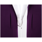
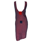
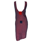
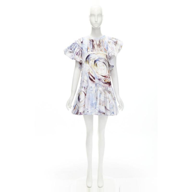
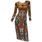
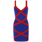
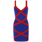
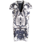
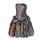
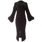
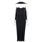
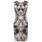
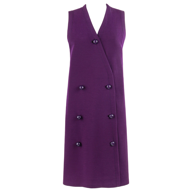
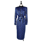
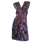
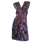
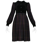
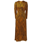
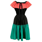
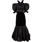
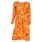
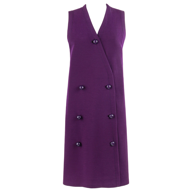
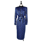
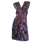
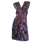
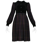
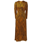
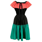
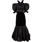
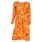
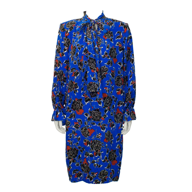
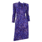
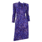
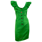
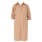
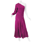
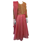
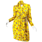
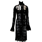
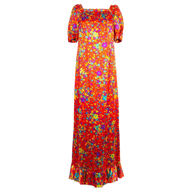
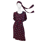
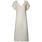
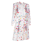
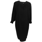
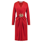
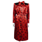
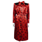
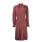
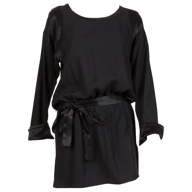
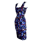
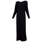
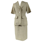
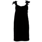
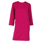
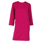
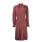
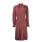
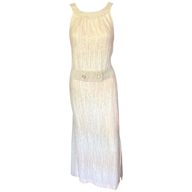
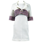
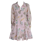
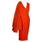
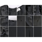
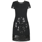
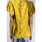
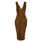
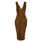
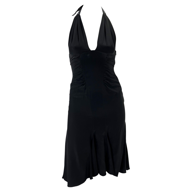
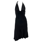
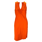
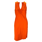
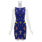
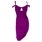
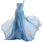
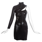
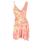
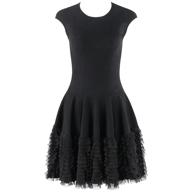
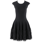
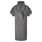
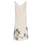
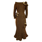
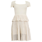
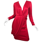
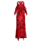
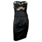
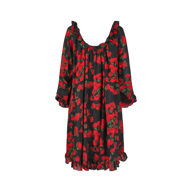
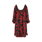
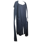
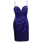
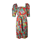
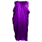
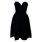
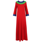
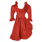
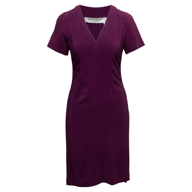
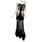
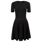
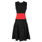
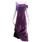
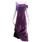
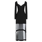
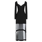
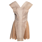
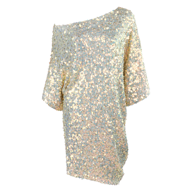
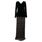
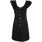
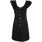
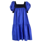
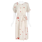
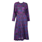
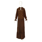
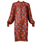
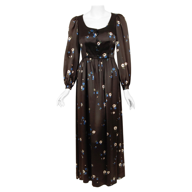
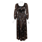
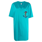
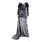
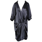
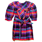
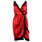
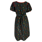
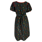
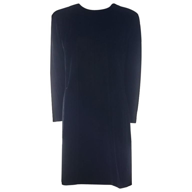
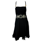
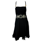
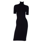
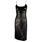
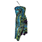
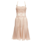
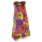
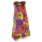
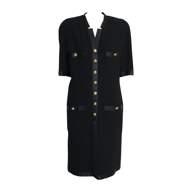
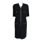
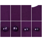
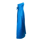
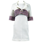
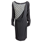
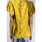
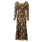
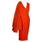
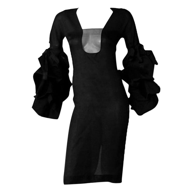
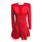
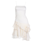
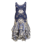
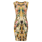
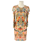
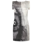
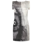
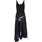
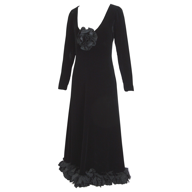
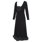
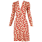
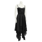
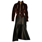
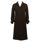
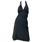
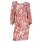
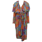
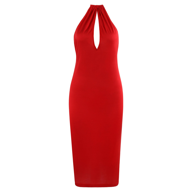
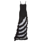
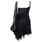
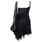
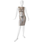
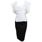
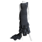
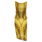
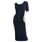
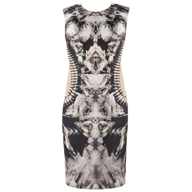
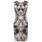
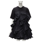
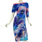
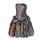
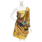
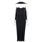
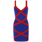
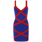
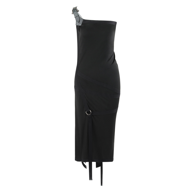
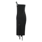
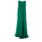
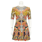
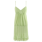
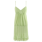
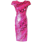
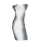
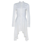
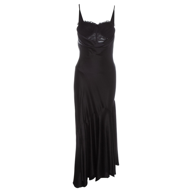
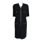
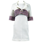
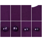
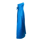
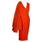
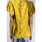
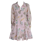
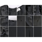
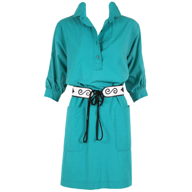
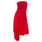
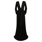
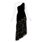
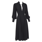
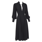
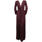
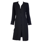
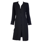

In [95]:
html_str = "<div style='display: flex;gap: 22px;flex-wrap: wrap;'>"
for i in sorted(range(n_test), key=lambda i: test_probabilities[test_classes[i],i])[:30]:
    top_5 = np.argsort(kernel_test_train[0][i])[::-1][:8]
    top_5_figures = ''.join([
        fr"""<div class="img-box small-box" data-class="{train_classes[j]}"><img src="{tensor_to_url(train_images[j], 42)}"></div>"""
        for j in top_5
    ])
    html_str += fr'''<div>
    <div style='margin: 0 auto; display: flex;'>
    <div class="img-box big-box border" style='border-right: 0 !important;' data-class="{test_classes[i]}">
        <img src="{tensor_to_url(test_images[i], 192)}">
    </div>
    <div class="small-holder">{top_5_figures}</div>
    </div>
    <pre>
P(c={test_classes[i]}): {100*test_probabilities[test_classes[i],i].numpy(force=True):0.2f}%
Class:  {class_labels[test_classes[i]]}</pre> 
    </div>'''
html_str += '</div>'
ipd.HTML(html_str)